In [7]:
import numpy as np

In [8]:
import pandas as pd

In [10]:
import matplotlib.pyplot as plt

In [9]:
import xarray as xr

In [15]:
import cartopy.crs as ccrs

In [11]:
import matplotlib.patches as mpatches

In [12]:
%matplotlib inline

In [13]:
import geopandas as gpd

In [14]:
from geopandas.tools import overlay

In [16]:
from shapely.geometry import Point

In [17]:
from descartes import PolygonPatch

In [19]:
#opening and transfering data into an array
tempMax = xr.open_dataset("/home/mlopez/EXEC/Données test/tasmax_day_BNU-ESM_rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1956.nc")

In [20]:
tempMax

<xarray.Dataset>
Dimensions:       (lat: 700, lon: 1064, time: 365, ts: 3)
Coordinates:
  * ts            (ts) float32 nan nan nan
  * time          (time) object 1956-01-01 00:00:00 ... 1956-12-31 00:00:00
  * lat           (lat) float32 83.28931 83.20598 83.12265 ... 25.12497 25.04164
  * lon           (lon) float32 -141.04314 -140.9598 ... -52.54667 -52.46334
Data variables:
    time_vectors  (time, ts) int32 ...
    tasmax        (time, lat, lon) float32 ...
Attributes:
    Conventions:     CF-1.5
    title:           BNU-ESM model output prepared for CMIP5 historical
    history:         2012-03-12T06:02:50Z CMOR rewrote data to comply with CF...
    institution:     GCESS,BNU,Beijing,China
    source:          BNU-ESM\n30-day moving window 50-bins quantile mapping w...
    redistribution:  Redistribution prohibited. For internal use only.

In [21]:
#Transfering array to dataframe and droping NaN values
df = tempMax.to_dataframe().dropna()
df.head()

time_vectors      tasmax
lat       lon        time                ts                           
66.623306 -89.045212 1956-01-01 00:00:00 NaN          1956  240.807495
                                         NaN             1  240.807495
                                         NaN             1  240.807495
                     1956-01-02 00:00:00 NaN          1956  242.874939
                                         NaN             1  242.874939

# Plotting Timeseries

In [22]:
#Grouping by time. Getting rid off latitude and longitud for timeseries. We will plott the mean per day of max temperature
AllcoordTempMean = df.groupby("time").mean()
AllcoordTempMean.head()

,time_vectors,tasmax
time,,
1956-01-01 00:00:00,652.666667,261.011810
1956-01-02 00:00:00,653.000000,263.771912
1956-01-03 00:00:00,653.333333,264.666656
1956-01-04 00:00:00,653.666667,263.498505
1956-01-05 00:00:00,654.000000,261.698914


In [23]:
#Adding column of temperature in Celsius
TempMeanC = AllcoordTempMean
TempMeanC["tasmaxC"] = TempMeanC["tasmax"] -273.15
TempMeanC.head()


,time_vectors,tasmax,tasmaxC
time,,,
1956-01-01 00:00:00,652.666667,261.011810,-12.138184
1956-01-02 00:00:00,653.000000,263.771912,-9.378082
1956-01-03 00:00:00,653.333333,264.666656,-8.483337
1956-01-04 00:00:00,653.666667,263.498505,-9.651489
1956-01-05 00:00:00,654.000000,261.698914,-11.451080


Text(0.5, 1.0, 'Temperature Maximale')

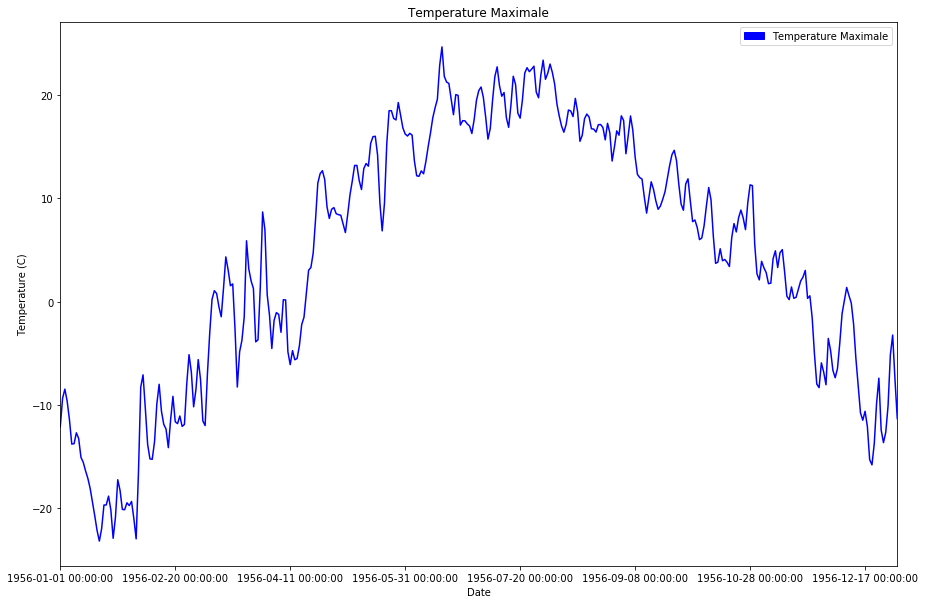

In [24]:
# plot time series
TempMeanC['tasmaxC'].plot.line('o-',color='blue',figsize=(15,10))

# add colour reference
blue_patch = mpatches.Patch(color='blue', label='Temperature Maximale')
plt.legend(handles=[blue_patch,])

# add titles
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Temperature Maximale')


# Plotting Map

In [25]:
#Grouping by latitude and longitude. Getting rid off time by doing the mean of all the year for each location point
AlltimeTempMean = df.groupby(["lat","lon"]).mean()
AlltimeTempMean.head()

time_vectors      tasmax
lat       lon                                 
40.041039 -89.045212    659.415525  291.249939
          -88.961884    659.415525  291.233185
          -88.878548    659.415525  291.216064
          -88.795219    659.415525  291.142212
          -88.711891    659.415525  291.161682

In [26]:
#Adding column of temperature in Celsius
AlltimeTempMean["tasmaxC"] = AlltimeTempMean["tasmax"] -273.15

In [27]:
AlltimeTempMean.head()

time_vectors      tasmax    tasmaxC
lat       lon                                            
40.041039 -89.045212    659.415525  291.249939  18.099945
          -88.961884    659.415525  291.233185  18.083191
          -88.878548    659.415525  291.216064  18.066071
          -88.795219    659.415525  291.142212  17.992218
          -88.711891    659.415525  291.161682  18.011688

In [28]:
#Reseting index to get correctly lat and lon column names
GeoTempMeanC = AlltimeTempMean.reset_index()

In [29]:
GeoTempMeanC["tasmaxC"]

0        18.099945
1        18.083191
2        18.066071
3        17.992218
4        18.011688
           ...    
76201    -6.375854
76202    -6.743073
76203    -6.499664
76204    -6.419312
76205    -5.723694
Name: tasmaxC, Length: 76206, dtype: float32

In [30]:
GeoTempMeanC["lat"]

0        40.041039
1        40.041039
2        40.041039
3        40.041039
4        40.041039
           ...    
76201    66.623306
76202    66.623306
76203    66.623306
76204    66.623306
76205    66.623306
Name: lat, Length: 76206, dtype: float64

No handles with labels found to put in legend.


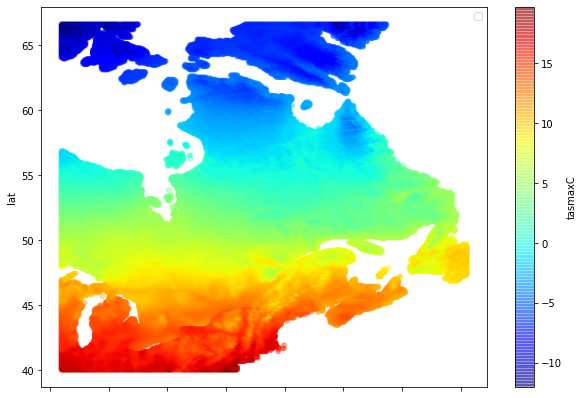

In [31]:
#Plotting map
GeoTempMeanC.plot(kind="scatter", x="lon", y="lat",
    c="tasmaxC", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

# Converting dataframe to geodataframe with poligon in order to merge through overlay with GeoPandas

In [32]:
GeoTempMeanC.head()

,lat,lon,time_vectors,tasmax,tasmaxC
0,40.041039,-89.045212,659.415525,291.249939,18.099945
1,40.041039,-88.961884,659.415525,291.233185,18.083191
2,40.041039,-88.878548,659.415525,291.216064,18.066071
3,40.041039,-88.795219,659.415525,291.142212,17.992218
4,40.041039,-88.711891,659.415525,291.161682,18.011688


In [33]:
geom = [Point(x,y) for x, y in zip(GeoTempMeanC['lon'], GeoTempMeanC['lat'])]
gdf = gpd.GeoDataFrame(GeoTempMeanC, geometry=geom)
print(gdf.head())

         lat        lon  time_vectors      tasmax    tasmaxC  \
0  40.041039 -89.045212    659.415525  291.249939  18.099945   
1  40.041039 -88.961884    659.415525  291.233185  18.083191   
2  40.041039 -88.878548    659.415525  291.216064  18.066071   
3  40.041039 -88.795219    659.415525  291.142212  17.992218   
4  40.041039 -88.711891    659.415525  291.161682  18.011688   

                     geometry  
0  POINT (-89.04521 40.04104)  
1  POINT (-88.96188 40.04104)  
2  POINT (-88.87855 40.04104)  
3  POINT (-88.79522 40.04104)  
4  POINT (-88.71189 40.04104)  


In [34]:
gdf.head()

,lat,lon,time_vectors,tasmax,tasmaxC,geometry
0,40.041039,-89.045212,659.415525,291.249939,18.099945,POINT (-89.04521 40.04104)
1,40.041039,-88.961884,659.415525,291.233185,18.083191,POINT (-88.96188 40.04104)
2,40.041039,-88.878548,659.415525,291.216064,18.066071,POINT (-88.87855 40.04104)
3,40.041039,-88.795219,659.415525,291.142212,17.992218,POINT (-88.79522 40.04104)
4,40.041039,-88.711891,659.415525,291.161682,18.011688,POINT (-88.71189 40.04104)


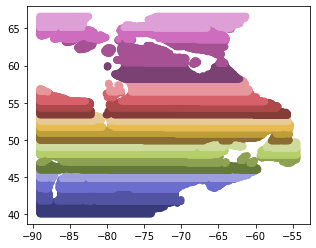

In [35]:
gdf.plot(cmap='tab20b')

## Converting geometry into MultiPolygon for overlay

In [36]:
from shapely.geometry import Point, Polygon

In [37]:
# Extract the coordinates from the Point object
gdf['geometry'] = gdf['geometry'].apply(lambda x: x.coords[0])

# Group by shape ID 
#  1. Get all of the coordinates for that ID as a list
#  2. Convert that list to a Polygon
gdf = gdf.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

# Declare the result as a new a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry = 'geometry')

gdf.plot()

KeyError: 'shape_id'

In [38]:
from geopandas import datasets, GeoDataFrame, read_file

# Importing Shapefile

In [41]:
dfs = gpd.read_file("/home/mlopez/EXEC/Shapefiles/DOM_BIO.shp")
dfs.columns.values

array(['OBJECTID', 'ZONE_VEG', 'SZONE_VEG', 'DOM_BIO', 'NOM',
       'SUPERFICIE', 'Shape_Leng', 'Shape_Area', 'TemMax', 'geometry'],
      dtype=object)

In [42]:
dfs

,OBJECTID,ZONE_VEG,SZONE_VEG,DOM_BIO,NOM,SUPERFICIE,Shape_Leng,Shape_Area,TemMax,geometry
0,1,None,None,None,None,25607428.6,164.992897,35.988962,None,"POLYGON ((-57.10894 51.41622, -57.10843 51.425..."
1,2,Z2,Z21,6,Pessière à mousses,2703332.1,19.934361,3.614118,None,"POLYGON ((-57.10885 51.80453, -57.10871 51.894..."
2,3,Z2,Z22,7,Pessière à lichens,146331.8,3.433543,0.197042,None,"POLYGON ((-63.62106 52.87605, -63.61877 52.885..."
3,4,Z2,Z22,7,Pessière à lichens,297815.4,7.177941,0.397690,None,"POLYGON ((-64.00001 52.73757, -63.99938 52.732..."
4,5,Z3,Z31,9,Toundra arctique arbustive,19449981.6,83.116253,30.841645,None,"POLYGON ((-69.59218 60.21848, -69.59202 60.214..."
...,...,...,...,...,...,...,...,...,...,...
1287,1288,Z2,Z22,7,Pessière à lichens,29016262.2,60.028484,40.552338,None,"POLYGON ((-66.93699 57.86419, -66.88774 57.855..."
1288,1289,Z2,Z23,8,Toundra forestière,629112.4,6.975767,0.894753,None,"POLYGON ((-67.48167 55.28456, -67.40291 55.279..."
1289,1290,Z2,Z23,8,Toundra forestière,20713843.3,54.337240,30.710562,None,"POLYGON ((-69.92814 58.55252, -69.88419 58.547..."
1290,1291,Z3,Z31,10,Toundra arctique herbacée,35894.8,1.755321,0.050682,None,"POLYGON ((-79.23661 54.79864, -79.25587 54.784..."


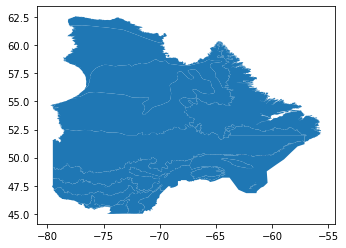

In [43]:
dfs.plot()

In [44]:
b = [int(x) for x in dfs.total_bounds]
N = 10

polydf2 = GeoDataFrame([
    {'geometry': Point(x, y).buffer(10000), 'value1': x + y, 'value2': x - y}
    for x, y in zip(range(b[0], b[2], int((b[2] - b[0]) / N)),
                   range(b[1], b[3], int((b[3] - b[1]) / N)))
])

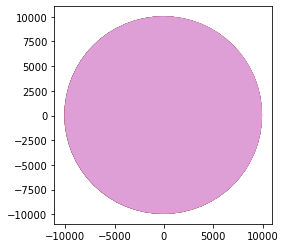

In [45]:
polydf2.plot(cmap='tab20b')

In [46]:
polydf2.head()

,geometry,value1,value2
0,"POLYGON ((9921.000 44.000, 9872.847 -936.171, ...",-35,-123
1,"POLYGON ((9923.000 45.000, 9874.847 -935.171, ...",-32,-122
2,"POLYGON ((9925.000 46.000, 9876.847 -934.171, ...",-29,-121
3,"POLYGON ((9927.000 47.000, 9878.847 -933.171, ...",-26,-120
4,"POLYGON ((9929.000 48.000, 9880.847 -932.171, ...",-23,-119


# Performing overlay

In [47]:
import rtree

In [48]:
newfd = overlay(dfs, polydf2, how="intersection")

NameError: name 'newdf' is not defined

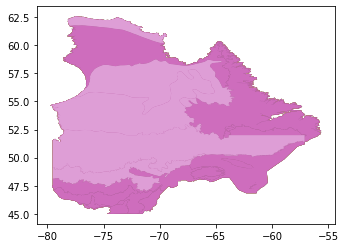

In [49]:
newfd.plot(cmap= 'tab20b')

In [51]:
newfd.head()

,OBJECTID,ZONE_VEG,SZONE_VEG,DOM_BIO,NOM,SUPERFICIE,Shape_Leng,Shape_Area,TemMax,value1,value2,geometry
0,1,None,None,None,None,25607428.6,164.992897,35.988962,None,-35,-123,"POLYGON ((-57.10894 51.41622, -57.10843 51.425..."
1,2,Z2,Z21,6,Pessière à mousses,2703332.1,19.934361,3.614118,None,-35,-123,"POLYGON ((-57.10885 51.80453, -57.10871 51.894..."
2,3,Z2,Z22,7,Pessière à lichens,146331.8,3.433543,0.197042,None,-35,-123,"POLYGON ((-63.62106 52.87605, -63.61877 52.885..."
3,4,Z2,Z22,7,Pessière à lichens,297815.4,7.177941,0.397690,None,-35,-123,"POLYGON ((-64.00001 52.73757, -63.99938 52.732..."
4,5,Z3,Z31,9,Toundra arctique arbustive,19449981.6,83.116253,30.841645,None,-35,-123,"POLYGON ((-69.59218 60.21848, -69.59202 60.214..."


# GeoPandas.sjoin

In [52]:
from geopandas.tools import sjoin

In [53]:
#point = geopandas.GeoDataFrame.from_file('point.shp') # or geojson etc - gdf
#poly = geopandas.GeoDataFrame.from_file('poly.shp') - dfs
pointInPolys = sjoin(gdf, dfs, how='left')


/home/mlopez/EXEC/anaconda3/envs/python37-2/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4269'})
  warn(


AttributeError: 'tuple' object has no attribute 'is_empty'

Exception ignored in: <function Handle.__del__ at 0x7f746c8e95e0>
Traceback (most recent call last):
  File "/home/mlopez/EXEC/anaconda3/envs/python37-2/lib/python3.8/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/home/mlopez/EXEC/anaconda3/envs/python37-2/lib/python3.8/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'


AttributeError: 'NoneType' object has no attribute 'intersection'

In [ ]:
pointSumByPoly = pointInPolys.groupby('PolyGroupByField')['fields', 'in', 'grouped', 'output'].agg(['sum'])